In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [6]:
# read the csv file into a DataFrame
df = pd.read_csv(r'testdata_preprocessed_predicted.csv')

df_test = pd.read_csv(r'testdata.csv')
df_supplemental = pd.read_csv(r'validdata_temp.csv')
df_trainingdata = pd.read_csv(r'traindata_temp.csv')

df_primary = df_trainingdata.copy()
df_supplemental = df_supplemental.copy()

df_supplemental.head()

,Unnamed: 0,Unnamed: 0.1,category,city,company_name,geo,job_board,job_description,job_requirements,job_title,job_type,post_date,salary_offered,state,class
0,8127,23128,factory jobs,Tamworth,Jobs in Science,uk,reed,Apply now My client is looking for two new pr...,Required skills Machinery Matching Print Pape...,Printer Operator (Temp to Perm),"Permanent, full-time",3/7/2018,£9.00 - £10.00 per hour,Staffordshire,9
1,4321,14495,accountancy jobs,Exeter,Meridian Business Support,uk,reed,Apply now Accounts Assistant Exeter AAT quali...,Required skills AAT,Accounts Assistant,"Permanent, full-time",3/12/2018,Salary negotiable,Devon,3
2,450,36244,construction property jobs,Preston,Search Consultancy,uk,reed,Apply now Summary:An Estimator is required to...,NaN,Estimator,"Permanent, full-time",2/27/2018,"£40,000 - £50,000 per annum, negotiable, pro-...",Lancashire,2
3,5798,20428,banking jobs,City of London,Ascension Global Recruitment Limited,uk,reed,Apply now On-boarding Compliance Team Leader ...,NaN,On-boarding Compliance Team Leader - Up to Â£5...,"Permanent, full-time",3/8/2018,"£40,000 - £50,000 per annum",London,13
4,5181,46985,purchasing jobs,Cheshire,Inside Out Purchasing & Supply,uk,reed,Apply now Inside Out Purchasing & Supply has ...,Required skills Buying Category Procurement P...,Buyer,"Permanent, full-time",3/6/2018,"£27,000 per annum",North West England,9


In [12]:
n_iterations = 10
step_value = 100

log_accuracy = []
log_records = []
log_weighted_f1 = []
log_weighted_precision = []
log_weighted_recall = []
log_iteration = list(range(0, n_iterations))

for i in range(n_iterations):

    # create the training datasets
    def sample_without_replacement(dataframe):
        sample = dataframe[0:step_value]
        replace = dataframe.drop(dataframe.index[0:step_value])
        return replace, sample
    
    # create a definition to be able to write over the original training and supplemental datasets
    def run_iteration(primarydata, supplementaldata):
        
        # create two datasets, one to add to the primary and one to return at the end
        df_supplemental, sample = sample_without_replacement(supplementaldata)

        # add new data into training dataset
        df_primary = primarydata.append(sample)

        # map each word in our training narratives to a vector position
        vectorizer = CountVectorizer()
        vectorizer.fit(df_primary['job_title'])

        # convert each training narrative to its vector representation and stack them into a matrix
        x_training = vectorizer.transform(df_primary['job_title'])
        x_validation = vectorizer.transform(df_test['job_title'])

        # y_training contains the codes associated with our training narratives
        y_training = df_primary['category']
        y_validation = df_test['category']

        # create model, predict
        clf = LogisticRegression(C=1.0)
        clf.fit(x_training, y_training)
        y_validation_pred = clf.predict(x_validation)

        # generate parameters
        accuracy = accuracy_score(y_validation, y_validation_pred)
        records = df_primary.shape[0]
        
        w_f1 = f1_score(y_validation, y_validation_pred, average = "weighted")
        w_precision = precision_score(y_validation, y_validation_pred, average = "weighted")
        w_recall = recall_score(y_validation, y_validation_pred, average = "weighted")    
        
        
        print("Iteration:", i+1, ", size of primary dataset: ",df_primary.shape[0],", supplemental: ", df_supplemental.shape[0])
        
        return df_primary, df_supplemental, accuracy, records, w_f1, w_precision , w_recall
    
    df_primary, df_supplemental, accuracy, records, w_f1, w_precision , w_recall = run_iteration(df_primary, df_supplemental)
    
    log_accuracy.append(accuracy)
    log_records.append(records)
    log_weighted_f1.append(w_f1)
    log_weighted_precision.append(w_precision)
    log_weighted_recall.append(w_recall)

# create a dataframe from the logged lists
df_iterations = pd.DataFrame(
    {'iteration': log_iteration,
     'records': log_records,
      'weighted_f1': log_weighted_f1,
      'weighted_precision': log_weighted_precision,
      'weighted_recall': log_weighted_recall   
     })
df_iterations.head()


Iteration: 1 , size of primary dataset:  7500 , supplemental:  1000
Iteration: 2 , size of primary dataset:  7600 , supplemental:  900
Iteration: 3 , size of primary dataset:  7700 , supplemental:  800
Iteration: 4 , size of primary dataset:  7800 , supplemental:  700
Iteration: 5 , size of primary dataset:  7900 , supplemental:  600
Iteration: 6 , size of primary dataset:  8000 , supplemental:  500
Iteration: 7 , size of primary dataset:  8100 , supplemental:  400
Iteration: 8 , size of primary dataset:  8200 , supplemental:  300
Iteration: 9 , size of primary dataset:  8300 , supplemental:  200
Iteration: 10 , size of primary dataset:  8400 , supplemental:  100


,iteration,records,weighted_f1,weighted_precision,weighted_recall
0,0,7500,0.660496,0.669270,0.665333
1,1,7600,0.662660,0.671988,0.666667
2,2,7700,0.663274,0.671507,0.667333
3,3,7800,0.665353,0.674235,0.669333
4,4,7900,0.669759,0.678869,0.673333


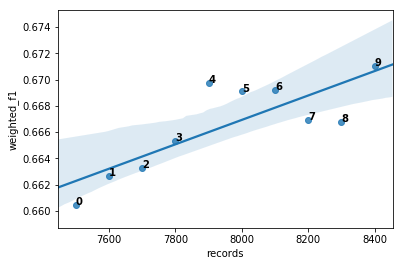

In [13]:
import matplotlib.pylab as plt
import seaborn as sns

p1 = sns.regplot(x=df_iterations["records"], y=df_iterations["weighted_f1"])

# add annotations one by one with a loop
for line in range(0,df_iterations.shape[0]):
     p1.text(df_iterations["records"][line]+0.4, df_iterations["weighted_f1"][line], df_iterations["iteration"][line], 
             horizontalalignment='left', size='medium', color='black', weight='semibold')
        